# 1. 당뇨환자의 재입원 예측
> **목차(Context)**

* Data Spec Check
* 문제해결 프로세스 정의
* Data Info Check
* Data Readiness Check
* Feature Engineering
* Modeling
* Model evaluation and Summary

## **Data Spec Check**

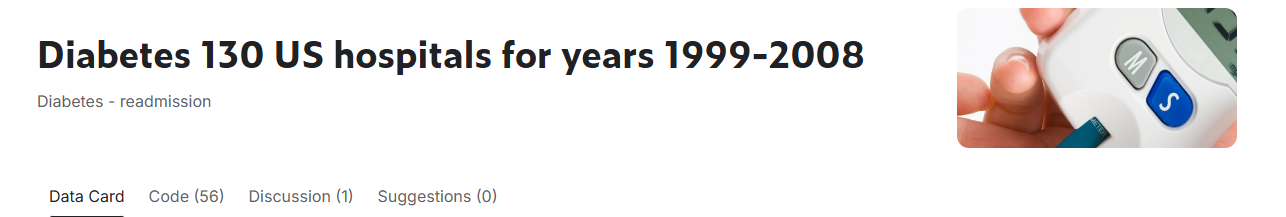

## **문제상황 설명**

```
1. 당뇨병 환자의 퇴원 후 30일 이내 조기 재입원을 예측할 수 있는가?
2. 고위험 환자를 선별하여 퇴원 교육 및 추적 관리를 집중할 대상자 리스트 추출
3. https://www.kaggle.com/datasets/brandao/diabetes/data?select=diabetic_data.csv
```
```
■ Check Point
   → 질병 데이터의 경우 Data Imbalance가 큰 경우가 많음
   → 질병에 걸린 사람보다 질병에 걸리지 않은 사람이 많기 때문
   → 하지만 이번 데이터에서는 Data Imbalance가 일어나지 않았음
   → 만약 Imbalance가 일어났을 경우 Class Weight를 주거나
      Data augmentation을 통해 데이터를 맞춰주는 작업이 필요함
      아니면 GAN을 활용하여 질병 데이터를 생산하는 방법도 있음
   → Bootstrap 수행 시 balance가 부족한 데이터는 무조건 뽑고,
      balance가 높은 데이터는 샘플링하여 뽑은 후 Tree를 구성하는 것도 하나의 방법임
```


## **Data info Check**

In [2]:
# === 0. 라이브러리 임포트 ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [3]:
# 한글 폰트 설정 (Colab용, 필요시 주석 해제하여 설치)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 1 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,002 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 117528 files and direc

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("brandao/diabetes")

print("Path to dataset files:", path)

100%|██████████| 4.41M/4.41M [00:00<00:00, 160MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/brandao/diabetes/versions/1


In [5]:
import os
import pandas as pd

# 1. 다운로드된 경로 안에 어떤 파일들이 있는지 확인 (파일명 확인용)
print("다운로드된 파일 목록:", os.listdir(path))

다운로드된 파일 목록: ['description.pdf', 'diabetic_data.csv']


In [6]:
# 2. CSV 파일 경로 결합
# (이 데이터셋의 메인 파일명은 보통 'diabetic_data.csv' 입니다.)
csv_file_path = os.path.join(path, 'diabetic_data.csv')

In [7]:
# 3. 판다스로 데이터 불러오기
try:
    df = pd.read_csv(csv_file_path)
    print("\n✅ 데이터 로드 성공!")
    print(f"데이터 크기: {df.shape}")
    print(df.head(3)) # 상위 3개 행만 미리보기
except FileNotFoundError:
    print("\n❌ 파일을 찾을 수 없습니다. 위 '다운로드된 파일 목록'에서 정확한 파일명을 확인해주세요.")


✅ 데이터 로드 성공!
데이터 크기: (101766, 50)
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No   
1                 3  ...          No      Up                   No   
2                 2  ...          No      No                   No   

   glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                   No           

In [8]:
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


[Data 설명]
- encounter_id : Unique identifier of an encounter (내원 고유 ID)
- patient_nbr : Unique identifier of a patient (환자 등록 번호)
- race : Race of the patient (인종)
  - Values: Caucasian (백인), AfricanAmerican (흑인), Asian (아시아인), Hispanic (히스패닉), Other (기타)
- gender : Gender of the patient (성별)
    - Values: Female (여성), Male (남성)
- age : Age grouped in 10-year intervals (연령대)
    - Values: [0-10), [10-20), ..., [90-100)
- weight : Weight in pounds (체중)
    - Note: 결측치가 많아(약 97%) 분석에서 제외하는 경우가 많음.

- admission_type_id : Integer identifier corresponding to admission type (입원 경로)
    - 1 = Emergency (응급)
    - 2 = Urgent (긴급)
    - 3 = Elective (선택적/예약 입원)
    - 5 = Trauma Center (외상 센터)


- discharge_disposition_id : Integer identifier corresponding to discharge disposition (퇴원 형태)
    - 1 = Discharged to home (귀가)
    - 3 = Discharged to SNF (전문요양시설로 전원)
    - 11 = Expired (사망 - 재입원 예측 시 제외 필요)
    - 13, 14 = Hospice (호스피스 - 재입원 예측 시 제외 필요)


- admission_source_id : Integer identifier corresponding to admission source (입원 원인 제공처)
    - 1 = Physician Referral (의사 의뢰)
    - 7 = Emergency Room (응급실 내원)


- time_in_hospital : Integer number of days between admission and discharge (재원 기간 - 일 단위)

- payer_code : Integer identifier corresponding to payer code (보험 유형 / 지불자 코드)
    - Values: MC (Medicaid), HM (HMO), SP (Self-pay) 등 (결측치 많음)

- medical_specialty : Specialty of the admitting physician (담당 진료과)
    - Values: Cardiology (심장내과), InternalMedicine (내과), Surgery (외과) 등 (결측치 많음)

- num_lab_procedures : Number of lab tests performed during the encounter (검체 검사 횟수)
    - Note: 혈액 검사 등 진단 검사 총 횟수

- num_procedures : Number of procedures (other than lab tests) performed (시술 및 수술 횟수)
    - Note: Lab 검사를 제외한 비검체 처치 횟수

- num_medications : Number of distinct generic names administered during the encounter (투약 약물 개수)
    - Note: 간호사의 투약 업무량과 직결되는 변수

- number_outpatient : Number of outpatient visits in the year preceding the encounter (최근 1년 외래 방문 횟수)

- number_emergency : Number of emergency visits in the year preceding the encounter (최근 1년 응급실 방문 횟수)

- number_inpatient : Number of inpatient visits in the year preceding the encounter (최근 1년 입원 횟수)

- Note: 과거 입원 이력은 재입원의 강력한 예측 인자임
    - diag_1 : The primary diagnosis (Code: ICD-9) (주진단) diag_2 : Secondary diagnosis (Code: ICD-9) (부진단 1) diag_3 : Additional secondary diagnosis (Code: ICD-9) (부진단 2)
    - Values: 250.xx (Diabetes), 414.xx (Ischemic Heart Disease) 등 질병 분류 코드

- number_diagnoses : Number of diagnoses entered to the system (입력된 진단명 총 개수)

- max_glu_serum : Glucose serum test result (혈당 검사 결과)
    - 200 (200 이상)
    - 300 (300 이상)
    - Norm (정상)
    - None (검사 안 함)

- A1Cresult : Hemoglobin A1c test result (당화혈색소 검사 결과)
    - 8 (8% 초과 - 조절 안됨)
    - 7 (7% 초과)
    - Norm (정상)
    - None (검사 안 함)

- metformin, repaglinide, insulin, etc. : (총 24개 약물 컬럼) Indicates if the drug was prescribed or there was a change in dosage (각 당뇨 약물 처방 상태)
    - Up (용량 증량)
    - Down (용량 감량)
    - Steady (용량 유지)
    - No (처방 안 함)

- change : Indicates if there was a change in diabetic medications (당뇨 약물 변경 여부)
    - Ch (Changed - 변경됨)
    - No (No change - 변경 없음)

- diabetesMed : Indicates if there was any diabetic medication prescribed (당뇨 약물 처방 여부)
    - Yes (처방 있음)
    - No (처방 없음)

- readmitted : Days to inpatient readmission (재입원 여부 - Target Variable)
    - <30 (30일 이내 재입원 : Target Class = 1)
    - 30 (30일 이후 재입원)
    - NO (재입원 없음)

In [9]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [11]:
# Y에 대한 정보
df['readmitted'].unique()

array(['NO', '>30', '<30'], dtype=object)

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64


<Axes: xlabel='readmitted', ylabel='count'>

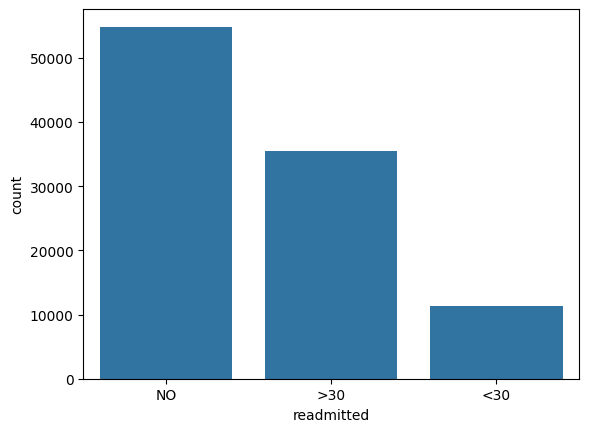

In [12]:
target = df['readmitted']
target_dist = df.readmitted.value_counts()
print(target_dist)
sns.countplot(x=target)

In [13]:
print("shape:", df.shape)
display(df.head(3))

# 1) 기본 스키마
display(df.dtypes.value_counts())
df.info(verbose=True, show_counts=True)

shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO


,count
object,37
int64,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [14]:
# 2) 타깃 분포 (원본)
if "readmitted" in df.columns:
    display(df["readmitted"].value_counts(dropna=False))
    display(df["readmitted"].value_counts(normalize=True, dropna=False).rename("ratio"))

,count
readmitted,
NO,54864
>30,35545
<30,11357


,ratio
readmitted,
NO,0.539119
>30,0.349282
<30,0.111599


2) 타깃(문제정의) 준비상태

- 체크: readmitted 분포/불균형 정도

- 관찰: NO 53.9%, >30 34.9%, <30 11.16% → 이진(<30 vs 나머지) 시 양성 11% 수준(불균형 존재)

- 평가지표: ROC-AUC만 말고 PR-AUC, Recall(특히 <30) 같이 보기

- 모델 옵션: class_weight="balanced" 또는 threshold 튜닝

In [15]:
# 3) '?' 같은 특수 결측 표기 확인
# (이 데이터는 '?'를 결측으로 쓰는 경우가 많음)
qmark_cols = []
for c in df.columns:
    if df[c].dtype == "object":
        if (df[c] == "?").any():
            qmark_cols.append(c)
print("Columns containing '?':", qmark_cols)

Columns containing '?': ['race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3']


In [16]:
# 4) 결측 리포트(?, NaN 모두 포함)
tmp = df.copy()
tmp = tmp.replace("?", np.nan)

missing = (tmp.isna().mean().sort_values(ascending=False)*100).round(2)
missing = missing[missing > 0]
display(missing.to_frame("missing_%"))

,missing_%
weight,96.86
max_glu_serum,94.75
A1Cresult,83.28
medical_specialty,49.08
payer_code,39.56
race,2.23
diag_3,1.40
diag_2,0.35
diag_1,0.02


3) 결측(Missingness) & 결측 표기 통일

- 체크: 결측 표기가 여러 개인지(?, None, Unknown/Invalid, 공백 등)

- 관찰

    - 포함 컬럼: race, weight, payer_code, medical_specialty, diag_1, diag_2, diag_3

    - 결측률: weight 96.86% (사실상 사용 어려움), medical_specialty 49.08%, payer_code 39.56%, race 2.23%, diag_*는 낮음

    - max_glu_serum 94.75%, A1Cresult 83.28%가 “결측”으로 찍혔는데 이건 진짜 NaN인지, ‘None’ 같은 문자열이 NaN으로 파싱된 건지 반드시 확인해야 함(중요!)

- 해결방법

    - weight는 보통 drop 후보(정보 거의 없음)

    - max_glu_serum, A1Cresult는 원래 데이터에서 ‘None’도 하나의 범주로 쓰는 경우가 많아서(검사 안 함 의미), “결측” 처리하면 정보 손실 가능 → 토큰 확인 후 정책 결정

    - medical_specialty, payer_code는 결측을 "MISSING" 범주로 두고, 희귀 범주는 "OTHER"로 합치기

In [18]:
# 5) 범주형 카디널리티(유니크 개수) → 원핫 위험/희소성 체크
cat_cols = [c for c in tmp.columns if tmp[c].dtype == "object"]
card = tmp[cat_cols].nunique(dropna=False).sort_values(ascending=False)
display(card.to_frame("n_unique").head(30))

,n_unique
diag_3,790
diag_2,749
diag_1,717
medical_specialty,73
payer_code,18
age,10
weight,10
race,6
glyburide-metformin,4
max_glu_serum,4


5) 카디널리티(범주 폭발) & 인코딩 가능성

- 체크: 원핫 시 차원 폭발하는 컬럼 존재 여부

- 관찰

    - diag_1/2/3 유니크가 700~800대 → 원핫 그대로 하면 폭발

    - medical_specialty 73(중간), payer_code 18(낮음)

- 해결방법

    - diag_*는 ICD-9 대분류로 그룹화(예: 001–139 감염, 390–459 순환기…) 또는 최소한 상위 N개 + OTHER

    - medical_specialty도 빈도 낮은 전공은 OTHER

    - 이 단계는 readiness의 핵심: “모델에 넣을 수 있는 형태로 만들 수 있나?”

In [19]:
# 6) 수치형 요약
num_cols = [c for c in tmp.columns if pd.api.types.is_numeric_dtype(tmp[c])]
display(tmp[num_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
encounter_id,101766.0,1.652016e+08,1.026403e+08,12522.0,84961194.0,152388987.0,2.302709e+08,443867222.0
patient_nbr,101766.0,5.433040e+07,3.869636e+07,135.0,23413221.0,45505143.0,8.754595e+07,189502619.0
admission_type_id,101766.0,2.024006e+00,1.445403e+00,1.0,1.0,1.0,3.000000e+00,8.0
discharge_disposition_id,101766.0,3.715642e+00,5.280166e+00,1.0,1.0,1.0,4.000000e+00,28.0
admission_source_id,101766.0,5.754437e+00,4.064081e+00,1.0,1.0,7.0,7.000000e+00,25.0
time_in_hospital,101766.0,4.395987e+00,2.985108e+00,1.0,2.0,4.0,6.000000e+00,14.0
num_lab_procedures,101766.0,4.309564e+01,1.967436e+01,1.0,31.0,44.0,5.700000e+01,132.0
num_procedures,101766.0,1.339730e+00,1.705807e+00,0.0,0.0,1.0,2.000000e+00,6.0
num_medications,101766.0,1.602184e+01,8.127566e+00,1.0,10.0,15.0,2.000000e+01,81.0
number_outpatient,101766.0,3.693572e-01,1.267265e+00,0.0,0.0,0.0,0.000000e+00,42.0


** 연속형 변수 확인**

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cols = [
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_outpatient",
    "number_emergency",
    "number_inpatient",
]

# df가 이미 로드되어 있다고 가정
# 타깃: <30 재입원 여부
df2 = df.copy()
df2["y_readmit30"] = (df2["readmitted"] == "<30").astype(int)

# 필요한 컬럼만
sub = df2[cols + ["y_readmit30"]].copy()

# 혹시 문자열이면 숫자로 변환(안전)
for c in cols:
    sub[c] = pd.to_numeric(sub[c], errors="coerce")

In [29]:
summary = []
for c in cols:
    s = sub[c].dropna()
    summary.append({
        "var": c,
        "n": int(s.shape[0]),
        "missing_%": round(sub[c].isna().mean()*100, 3),
        "mean": round(s.mean(), 3),
        "std": round(s.std(), 3),
        "min": float(s.min()),
        "p25": float(s.quantile(0.25)),
        "median": float(s.median()),
        "p75": float(s.quantile(0.75)),
        "p95": float(s.quantile(0.95)),
        "p99": float(s.quantile(0.99)),
        "max": float(s.max()),
        "zero_%": round((s==0).mean()*100, 3),
    })

summary_df = pd.DataFrame(summary).sort_values("var")
display(summary_df)

,var,n,missing_%,mean,std,min,p25,median,p75,p95,p99,max,zero_%
0,num_lab_procedures,101766,0.0,43.096,19.674,1.0,31.0,44.0,57.0,73.0,85.0,132.0,0.000
2,num_medications,101766,0.0,16.022,8.128,1.0,10.0,15.0,20.0,31.0,43.0,81.0,0.000
1,num_procedures,101766,0.0,1.340,1.706,0.0,0.0,1.0,2.0,5.0,6.0,6.0,45.842
4,number_emergency,101766,0.0,0.198,0.930,0.0,0.0,0.0,0.0,1.0,3.0,76.0,88.815
5,number_inpatient,101766,0.0,0.636,1.263,0.0,0.0,0.0,1.0,3.0,6.0,21.0,66.456
3,number_outpatient,101766,0.0,0.369,1.267,0.0,0.0,0.0,0.0,2.0,5.0,42.0,83.551


In [30]:
g = sub.groupby("y_readmit30")

target_summary = g[cols].agg(["count","mean","median","std","min","max"])
display(target_summary)

# 간단한 효과크기: 표준화 평균차(Cohen's d 느낌)
effect = []
for c in cols:
    a = sub.loc[sub["y_readmit30"]==1, c].dropna()
    b = sub.loc[sub["y_readmit30"]==0, c].dropna()
    pooled = np.sqrt((a.var(ddof=1) + b.var(ddof=1))/2)
    d = (a.mean() - b.mean()) / (pooled + 1e-12)
    effect.append({"var": c, "mean_pos": a.mean(), "mean_neg": b.mean(), "std_diff": d})
effect_df = pd.DataFrame(effect).sort_values("std_diff", ascending=False)
display(effect_df)

num_lab_procedures                                        \
                         count       mean median        std min  max   
y_readmit30                                                            
0                        90409  42.953644   44.0  19.719348   1  129   
1                        11357  44.226028   45.0  19.276087   1  132   

            num_procedures                             ... number_emergency  \
                     count      mean median       std  ...           median   
y_readmit30                                            ...                    
0                    90409  1.347123    1.0  1.714242  ...              0.0   
1                    11357  1.280884    1.0  1.635992  ...              0.0   

                              number_inpatient                                 \
                  std min max            count      mean median       std min   
y_readmit30                                                                     
0            0.857353   0  76            90409  0.561648    0.0  1.125315   0   
1            1.370384   0  64            11357  1.224003    0.0  1.954577   0   

                 
            max  
y_readmit30      
0            19  
1            21  

[2 rows x 36 columns]

,var,mean_pos,mean_neg,std_diff
5,number_inpatient,1.224003,0.561648,0.415325
4,number_emergency,0.357313,0.177803,0.157048
2,num_medications,16.903143,15.911137,0.122308
0,num_lab_procedures,44.226028,42.953644,0.065254
3,number_outpatient,0.436911,0.360871,0.059277
1,num_procedures,1.280884,1.347123,-0.039532


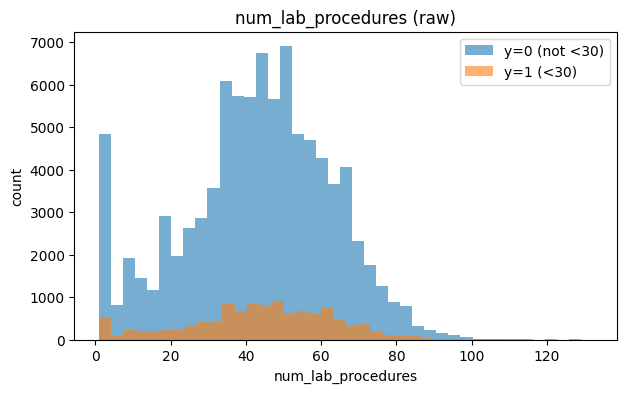

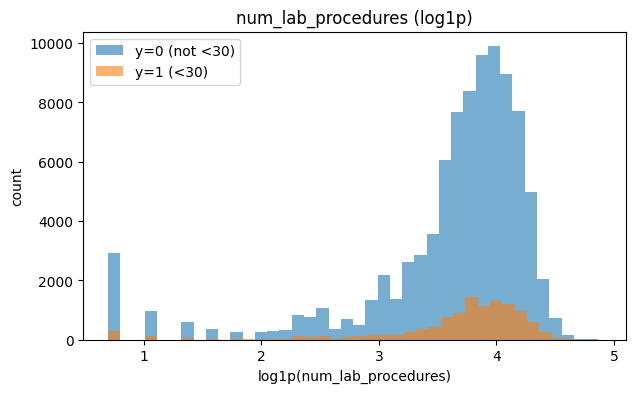

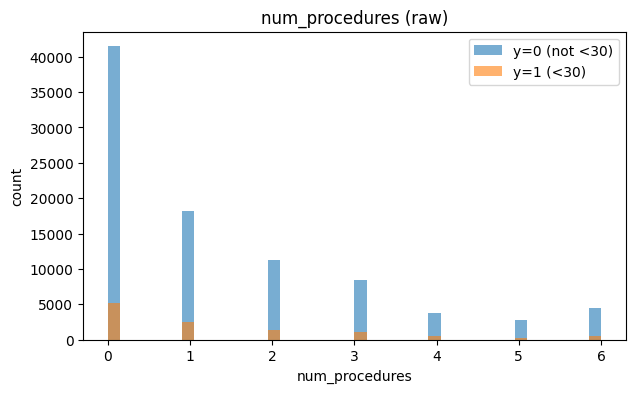

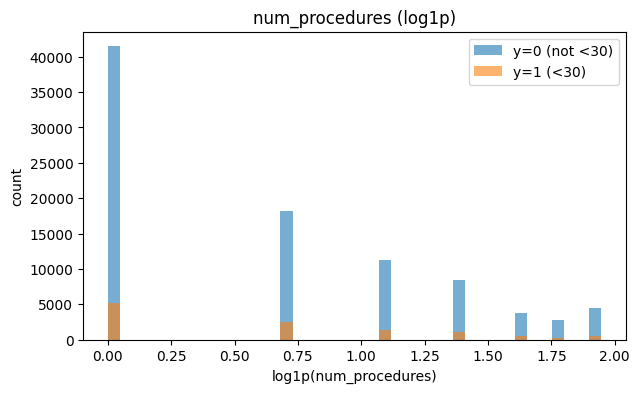

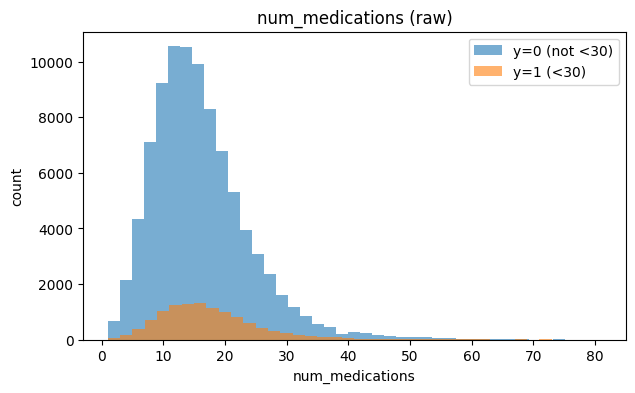

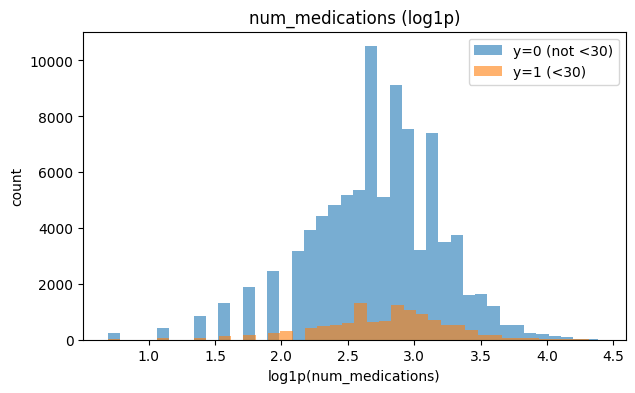

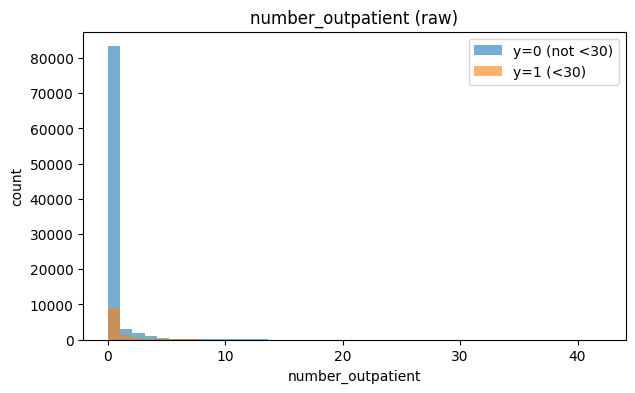

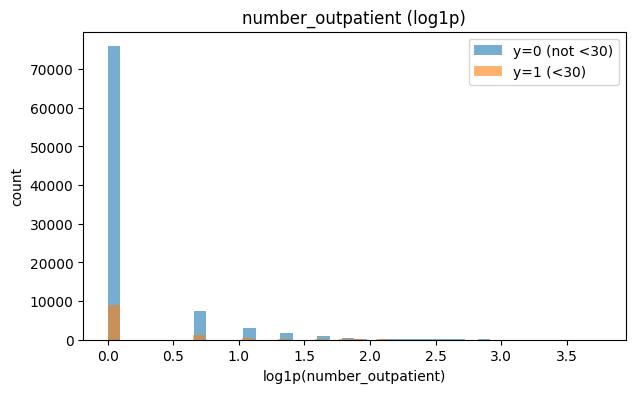

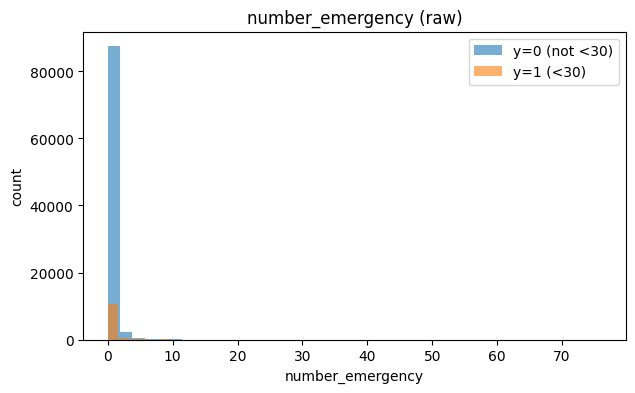

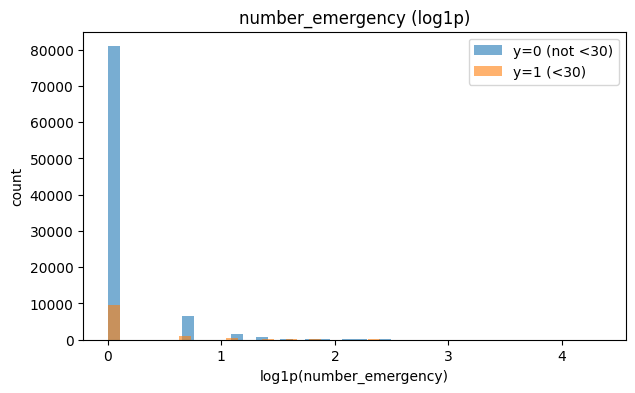

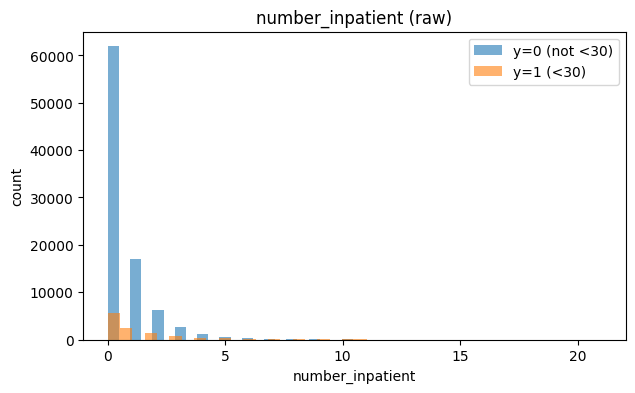

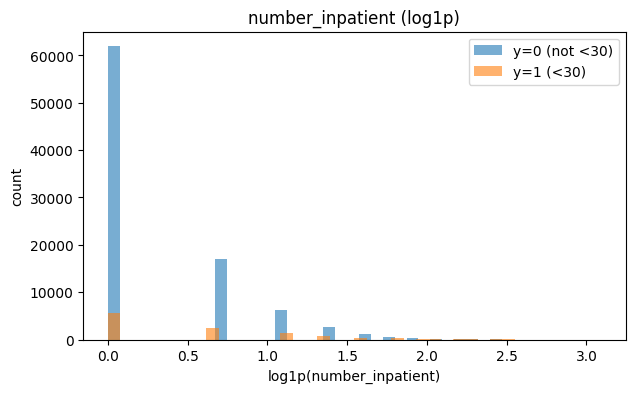

In [31]:
import math

def plot_hist_by_target(df_in, col):
    x0 = df_in.loc[df_in["y_readmit30"]==0, col].dropna()
    x1 = df_in.loc[df_in["y_readmit30"]==1, col].dropna()

    plt.figure(figsize=(7,4))
    plt.hist(x0, bins=40, alpha=0.6, label="y=0 (not <30)")
    plt.hist(x1, bins=40, alpha=0.6, label="y=1 (<30)")
    plt.title(f"{col} (raw)")
    plt.xlabel(col); plt.ylabel("count")
    plt.legend()
    plt.show()

    # log1p 변환 분포
    plt.figure(figsize=(7,4))
    plt.hist(np.log1p(x0), bins=40, alpha=0.6, label="y=0 (not <30)")
    plt.hist(np.log1p(x1), bins=40, alpha=0.6, label="y=1 (<30)")
    plt.title(f"{col} (log1p)")
    plt.xlabel(f"log1p({col})"); plt.ylabel("count")
    plt.legend()
    plt.show()

for c in cols:
    plot_hist_by_target(sub, c)

In [20]:
# 7) 환자/입원 단위 구조 확인 (누수 위험 체크)
for id_col in ["encounter_id", "patient_nbr"]:
    if id_col in tmp.columns:
        print(id_col, "nunique:", tmp[id_col].nunique(), " / rows:", len(tmp))
if "patient_nbr" in tmp.columns:
    vc = tmp["patient_nbr"].value_counts()
    print("Patients with >1 encounters:", (vc>1).sum(), " / max encounters per patient:", vc.max())

encounter_id nunique: 101766  / rows: 101766
patient_nbr nunique: 71518  / rows: 101766
Patients with >1 encounters: 16773  / max encounters per patient: 40


In [21]:
import pandas as pd
import numpy as np

def readiness_report(df: pd.DataFrame, target="readmitted", patient_id="patient_nbr", encounter_id="encounter_id"):
    print("=== Shape ===")
    print(df.shape)

    # 1) Target distribution
    if target in df.columns:
        print("\n=== Target distribution ===")
        vc = df[target].value_counts(dropna=False)
        print(vc)
        print((vc / len(df)).rename("ratio"))

    # 2) Special missing tokens check (핵심)
    special_tokens = ["?", "None", "Unknown/Invalid", "", " ", "NULL", "NaN"]
    obj_cols = [c for c in df.columns if df[c].dtype == "object"]

    print("\n=== Special missing token scan (object cols) ===")
    token_hits = {}
    for c in obj_cols:
        s = df[c].astype("string")
        hits = {}
        for t in special_tokens:
            hits[t] = int((s == t).sum())
        if sum(hits.values()) > 0:
            token_hits[c] = hits

    if token_hits:
        out = (pd.DataFrame(token_hits).T)
        display(out.loc[:, (out.sum(axis=0) > 0)])
    else:
        print("No special tokens found in object columns.")

    # 3) Replace '?' only (당신이 이미 한 방식) + 결측률
    tmp = df.replace("?", np.nan)
    miss = (tmp.isna().mean().sort_values(ascending=False) * 100).round(2)
    miss = miss[miss > 0]
    print("\n=== Missing rate (%) after replacing '?' -> NaN ===")
    display(miss.to_frame("missing_%"))

    # 4) Cardinality report
    print("\n=== Cardinality (n_unique) for object columns ===")
    card = tmp[obj_cols].nunique(dropna=False).sort_values(ascending=False)
    display(card.to_frame("n_unique").head(30))

    # 5) Leakage / duplicates
    print("\n=== ID / duplication checks ===")
    if encounter_id in df.columns:
        print("encounter_id nunique:", df[encounter_id].nunique(), "/ rows:", len(df),
              "/ duplicated:", int(df[encounter_id].duplicated().sum()))
    if patient_id in df.columns:
        print("patient_nbr nunique:", df[patient_id].nunique(), "/ rows:", len(df))
        vc_pat = df[patient_id].value_counts()
        print("patients with >1 encounters:", int((vc_pat > 1).sum()))
        print("max encounters per patient:", int(vc_pat.max()))

    # 6) Numeric vs coded-category hint
    print("\n=== Suspected coded categorical numeric columns (_id with low unique) ===")
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    coded = []
    for c in num_cols:
        if c.endswith("_id") and df[c].nunique() <= 30:
            coded.append((c, int(df[c].nunique())))
    display(pd.DataFrame(coded, columns=["col", "n_unique"]).sort_values("n_unique"))

# 실행
readiness_report(df)

=== Shape ===
(101766, 50)

=== Target distribution ===
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64
readmitted
NO     0.539119
>30    0.349282
<30    0.111599
Name: ratio, dtype: float64

=== Special missing token scan (object cols) ===


,?,Unknown/Invalid
race,2273,0
gender,0,3
weight,98569,0
payer_code,40256,0
medical_specialty,49949,0
diag_1,21,0
diag_2,358,0
diag_3,1423,0



=== Missing rate (%) after replacing '?' -> NaN ===


,missing_%
weight,96.86
max_glu_serum,94.75
A1Cresult,83.28
medical_specialty,49.08
payer_code,39.56
race,2.23
diag_3,1.40
diag_2,0.35
diag_1,0.02



=== Cardinality (n_unique) for object columns ===


,n_unique
diag_3,790
diag_2,749
diag_1,717
medical_specialty,73
payer_code,18
age,10
weight,10
race,6
glyburide-metformin,4
max_glu_serum,4



=== ID / duplication checks ===
encounter_id nunique: 101766 / rows: 101766 / duplicated: 0
patient_nbr nunique: 71518 / rows: 101766
patients with >1 encounters: 16773
max encounters per patient: 40

=== Suspected coded categorical numeric columns (_id with low unique) ===


,col,n_unique
0,admission_type_id,8
2,admission_source_id,17
1,discharge_disposition_id,26


## **Data Readiness Check**

In [22]:
import pandas as pd
import numpy as np

TARGET_COL = "readmitted"
POS_LABEL = "<30"
PATIENT_ID = "patient_nbr"
ENCOUNTER_ID = "encounter_id"

MISSING_TOKENS = ["?", "None", "NONE", "Unknown/Invalid", "Unknown", "NULL", "NaN", "", " "]

DROP_MISSING_THRESHOLD = 0.55      # 결측률 55% 초과 drop 후보
HIGH_CARD_THRESHOLD = 200          # 범주 유니크 200 이상 high-card
RARE_FREQ_THRESHOLD = 0.01         # 희귀 범주 OTHER(훈련 기준 1% 미만)
ID_NUMERIC_UNIQUE_MAX = 30         # _id numeric인데 유니크 <=30이면 categorical 후보

1) 타깃 준비 상태

In [23]:
assert TARGET_COL in df.columns, f"{TARGET_COL} 컬럼이 없습니다."

vc = df[TARGET_COL].value_counts(dropna=False)
ratio = (vc / len(df)).round(6)

print("=== Gate 1: Target distribution ===")
display(vc.to_frame("count"))
display(ratio.to_frame("ratio"))

pos_rate = float((df[TARGET_COL] == POS_LABEL).mean())
print(f"Positive rate ({POS_LABEL}): {pos_rate:.4f}")

# Gate 1 결론(간단)
if pos_rate < 0.2:
    print("-> Imbalance exists: PR-AUC/Recall + class_weight/threshold tuning recommended")
else:
    print("-> Imbalance not severe")

=== Gate 1: Target distribution ===


,count
readmitted,
NO,54864
>30,35545
<30,11357


,ratio
readmitted,
NO,0.539119
>30,0.349282
<30,0.111599


Positive rate (<30): 0.1116
-> Imbalance exists: PR-AUC/Recall + class_weight/threshold tuning recommended


In [24]:
df_g1 = df.copy()
df_g1["y_readmit30"] = (df_g1[TARGET_COL] == POS_LABEL).astype(int)
display(df_g1[["readmitted", "y_readmit30"]].head())

,readmitted,y_readmit30
0,NO,0
1,>30,0
2,NO,0
3,NO,0
4,NO,0


2. 결측 및 결측 표기 통일

In [25]:
print("=== Gate 2: Missing token scan ===")

obj_cols = [c for c in df_g1.columns if df_g1[c].dtype == "object"]

token_hits = {}
for c in obj_cols:
    s = df_g1[c].astype("string")
    counts = {t: int((s == t).sum()) for t in MISSING_TOKENS}
    if sum(counts.values()) > 0:
        token_hits[c] = counts

if token_hits:
    token_table = pd.DataFrame(token_hits).T
    token_table = token_table.loc[:, token_table.sum(axis=0) > 0]
    display(token_table)
else:
    print("No special missing tokens found in object columns.")

# '?'만 NaN으로 바꿔서 결측률 체크 (당신이 한 방식)
tmp = df_g1.replace("?", np.nan)
miss = (tmp.isna().mean().sort_values(ascending=False) * 100).round(2)
display(miss[miss > 0].to_frame("missing_%"))

# max_glu_serum / A1Cresult의 실제 값 확인(중요)
for c in ["max_glu_serum", "A1Cresult"]:
    if c in df_g1.columns:
        print(f"\nTop values (raw) for {c}:")
        display(df_g1[c].astype("string").value_counts(dropna=False).head(15))

=== Gate 2: Missing token scan ===


,?,Unknown/Invalid
race,2273,0
gender,0,3
weight,98569,0
payer_code,40256,0
medical_specialty,49949,0
diag_1,21,0
diag_2,358,0
diag_3,1423,0


,missing_%
weight,96.86
max_glu_serum,94.75
A1Cresult,83.28
medical_specialty,49.08
payer_code,39.56
race,2.23
diag_3,1.40
diag_2,0.35
diag_1,0.02



Top values (raw) for max_glu_serum:


,count
max_glu_serum,
<NA>,96420
Norm,2597
>200,1485
>300,1264



Top values (raw) for A1Cresult:


,count
A1Cresult,
<NA>,84748
>8,8216
Norm,4990
>7,3812


In [26]:
print("=== Gate 2: Normalize missing tokens ===")

df_g2 = df_g1.copy()
for t in MISSING_TOKENS:
    df_g2 = df_g2.replace(t, np.nan)

missing_rate = df_g2.isna().mean()
high_missing_cols = missing_rate[missing_rate > DROP_MISSING_THRESHOLD].index.tolist()
print(f"Drop candidates (missing > {DROP_MISSING_THRESHOLD*100:.0f}%):", high_missing_cols)

# 실제 drop은 다음 Gate까지 미뤄도 되고, 여기서 바로 해도 됨(정책 선택)
df_g2_ready = df_g2.drop(columns=high_missing_cols, errors="ignore")
print("After dropping high-missing cols:", df_g2_ready.shape)

=== Gate 2: Normalize missing tokens ===
Drop candidates (missing > 55%): ['weight', 'max_glu_serum', 'A1Cresult']
After dropping high-missing cols: (101766, 48)


3.  범주 제한 & 인코딩 가능성

In [32]:
print("=== Gate 3: Cardinality check ===")
obj_cols = [c for c in df_g2_ready.columns if df_g2_ready[c].dtype == "object"]
card = df_g2_ready[obj_cols].nunique(dropna=False).sort_values(ascending=False)
display(card.to_frame("n_unique").head(30))

high_card_cols = card[card >= HIGH_CARD_THRESHOLD].index.tolist()
print(f"High-cardinality cols (>= {HIGH_CARD_THRESHOLD}):", high_card_cols)

=== Gate 3: Cardinality check ===


,n_unique
diag_3,790
diag_2,749
diag_1,717
medical_specialty,73
payer_code,18
age,10
race,6
glyburide-metformin,4
metformin,4
repaglinide,4


High-cardinality cols (>= 200): ['diag_3', 'diag_2', 'diag_1']


In [33]:
def icd9_group(code):
    if pd.isna(code):
        return "MISSING"
    s = str(code).strip()
    if s == "":
        return "MISSING"
    if s.startswith("E"):
        return "E_CODE"
    if s.startswith("V"):
        return "V_CODE"
    try:
        x = float(s)
    except:
        return "OTHER"

    if 1 <= x <= 139:   return "001-139_INFECT"
    if 140 <= x <= 239: return "140-239_NEOPLASM"
    if 240 <= x <= 279: return "240-279_ENDOCRINE"
    if 280 <= x <= 289: return "280-289_BLOOD"
    if 290 <= x <= 319: return "290-319_MENTAL"
    if 320 <= x <= 389: return "320-389_NERVOUS"
    if 390 <= x <= 459: return "390-459_CIRCULATORY"
    if 460 <= x <= 519: return "460-519_RESPIRATORY"
    if 520 <= x <= 579: return "520-579_DIGESTIVE"
    if 580 <= x <= 629: return "580-629_GENITOURINARY"
    if 630 <= x <= 679: return "630-679_PREGNANCY"
    if 680 <= x <= 709: return "680-709_SKIN"
    if 710 <= x <= 739: return "710-739_MUSCULOSKELETAL"
    if 740 <= x <= 759: return "740-759_CONGENITAL"
    if 760 <= x <= 779: return "760-779_PERINATAL"
    if 780 <= x <= 799: return "780-799_SYMPTOMS"
    if 800 <= x <= 999: return "800-999_INJURY"
    return "OTHER"

df_g3 = df_g2_ready.copy()

for c in ["diag_1", "diag_2", "diag_3"]:
    if c in df_g3.columns:
        df_g3[c] = df_g3[c].apply(icd9_group)

print("After grouping diag_*:")
for c in ["diag_1", "diag_2", "diag_3"]:
    if c in df_g3.columns:
        print(c, "n_unique:", df_g3[c].nunique(dropna=False))
        display(df_g3[c].value_counts(dropna=False).head(10))

After grouping diag_*:
diag_1 n_unique: 19


,count
diag_1,
390-459_CIRCULATORY,30336
240-279_ENDOCRINE,11459
460-519_RESPIRATORY,10407
520-579_DIGESTIVE,9208
780-799_SYMPTOMS,7636
800-999_INJURY,6974
580-629_GENITOURINARY,5078
710-739_MUSCULOSKELETAL,4957
140-239_NEOPLASM,3433


diag_2 n_unique: 19


,count
diag_2,
390-459_CIRCULATORY,31365
240-279_ENDOCRINE,21017
460-519_RESPIRATORY,10251
580-629_GENITOURINARY,7987
780-799_SYMPTOMS,4632
520-579_DIGESTIVE,3962
680-709_SKIN,3596
280-289_BLOOD,2926
290-319_MENTAL,2657


diag_3 n_unique: 19


,count
diag_3,
390-459_CIRCULATORY,29918
240-279_ENDOCRINE,26308
460-519_RESPIRATORY,6774
580-629_GENITOURINARY,6327
780-799_SYMPTOMS,4523
V_CODE,3814
520-579_DIGESTIVE,3572
290-319_MENTAL,3136
280-289_BLOOD,2490


4. 데이터 타입/의미 정합성

In [34]:
print("=== Gate 4: Suspected coded numeric (_id) ===")
num_cols = [c for c in df_g3.columns if pd.api.types.is_numeric_dtype(df_g3[c])]

suspected = []
for c in num_cols:
    if c.endswith("_id") and df_g3[c].nunique() <= ID_NUMERIC_UNIQUE_MAX:
        suspected.append((c, int(df_g3[c].nunique())))

suspected_df = pd.DataFrame(suspected, columns=["col", "n_unique"]).sort_values("n_unique")
display(suspected_df)

=== Gate 4: Suspected coded numeric (_id) ===


,col,n_unique
0,admission_type_id,8
2,admission_source_id,17
1,discharge_disposition_id,26


In [35]:
df_g4 = df_g3.copy()

for col, _ in suspected:
    if col in df_g4.columns:
        # Int64로 결측 유지 → string으로 변환
        df_g4[col] = df_g4[col].astype("Int64").astype("string")

print("Converted to categorical-like string:", [c for c, _ in suspected])

Converted to categorical-like string: ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']


5. leakage & 데이터 분할 전략

In [36]:
print("=== Gate 5: Leakage check ===")

if ENCOUNTER_ID in df_g4.columns:
    print("encounter_id nunique:", df_g4[ENCOUNTER_ID].nunique(), "/ rows:", len(df_g4))
    print("encounter_id duplicated:", int(df_g4[ENCOUNTER_ID].duplicated().sum()))

if PATIENT_ID in df_g4.columns:
    print("patient_nbr nunique:", df_g4[PATIENT_ID].nunique(), "/ rows:", len(df_g4))
    vc_pat = df_g4[PATIENT_ID].value_counts()
    print("patients with >1 encounters:", int((vc_pat > 1).sum()))
    print("max encounters per patient:", int(vc_pat.max()))
else:
    print("patient_nbr not found → group split not possible (not recommended)")

=== Gate 5: Leakage check ===
encounter_id nunique: 101766 / rows: 101766
encounter_id duplicated: 0
patient_nbr nunique: 71518 / rows: 101766
patients with >1 encounters: 16773
max encounters per patient: 40


In [37]:
from sklearn.model_selection import GroupShuffleSplit

def compress_rare_categories(train_df, test_df, col, min_freq=RARE_FREQ_THRESHOLD, missing_label="MISSING"):
    tr = train_df.copy()
    te = test_df.copy()

    tr[col] = tr[col].fillna(missing_label)
    te[col] = te[col].fillna(missing_label)

    vc = tr[col].value_counts(normalize=True, dropna=False)
    keep = vc[vc >= min_freq].index

    tr[col] = tr[col].where(tr[col].isin(keep), "OTHER")
    te[col] = te[col].where(te[col].isin(keep), "OTHER")
    return tr, te

# 1) 누수 방지 위해 식별자 / 원 타깃 drop 후 X,y 구성
drop_cols = [c for c in [TARGET_COL, ENCOUNTER_ID, PATIENT_ID] if c in df_g4.columns]
X_all = df_g4.drop(columns=drop_cols + ["y_readmit30"], errors="ignore")
y_all = df_g4["y_readmit30"].copy()

# 2) group split
assert PATIENT_ID in df.columns, "patient_nbr가 없어서 group split을 할 수 없습니다."
groups = df[PATIENT_ID]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr_idx, te_idx = next(gss.split(X_all, y_all, groups=groups))

X_train = X_all.iloc[tr_idx].copy()
X_test  = X_all.iloc[te_idx].copy()
y_train = y_all.iloc[tr_idx].copy()
y_test  = y_all.iloc[te_idx].copy()

print("Split:", X_train.shape, X_test.shape)
print("Pos rate train/test:", float(y_train.mean()), float(y_test.mean()))

# 3) 희귀 범주 OTHER (대표적으로 medical_specialty, payer_code)
for c in ["medical_specialty", "payer_code"]:
    if c in X_train.columns:
        X_train, X_test = compress_rare_categories(X_train, X_test, c)

print("After rare compression:")
for c in ["medical_specialty", "payer_code"]:
    if c in X_train.columns:
        print(c, "train n_unique:", X_train[c].nunique(dropna=False), "test n_unique:", X_test[c].nunique(dropna=False))

Split: (81613, 44) (20153, 44)
Pos rate train/test: 0.11280065675811451 0.10673348881059892
After rare compression:
medical_specialty train n_unique: 11 test n_unique: 11
payer_code train n_unique: 10 test n_unique: 10


## **Feature Engineering**

In [38]:
import numpy as np
import pandas as pd

def feature_engineer_counts_and_util(df_in: pd.DataFrame) -> pd.DataFrame:
    """
    - 카운트형 log1p
    - 0 vs >0 지표
    - 방문 총합/비율
    - 입원기간 대비 강도
    - 처치 총합
    """
    df = df_in.copy()

    count_cols = [
        "num_lab_procedures","num_procedures","num_medications",
        "number_outpatient","number_emergency","number_inpatient"
    ]
    # 숫자 변환(안전)
    for c in count_cols + ["time_in_hospital"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # 1) log1p
    for c in count_cols:
        if c in df.columns:
            df[f"log1p_{c}"] = np.log1p(df[c].fillna(0))

    # 2) 0 vs >0
    for c in ["number_outpatient","number_emergency","number_inpatient"]:
        if c in df.columns:
            df[f"has_{c}"] = (df[c].fillna(0) > 0).astype(int)

    # 3) 방문 총합/응급 비중
    if all(c in df.columns for c in ["number_outpatient","number_emergency","number_inpatient"]):
        total = df["number_outpatient"].fillna(0) + df["number_emergency"].fillna(0) + df["number_inpatient"].fillna(0)
        df["prior_visits_total"] = total
        df["emergency_share"] = df["number_emergency"].fillna(0) / (total + 1)

    # 4) 입원기간 대비 강도
    if "time_in_hospital" in df.columns:
        t = df["time_in_hospital"].fillna(0)
        if "num_lab_procedures" in df.columns:
            df["labs_per_day"] = df["num_lab_procedures"].fillna(0) / (t + 1)
        if "num_medications" in df.columns:
            df["meds_per_day"] = df["num_medications"].fillna(0) / (t + 1)
        if "num_procedures" in df.columns:
            df["procedures_per_day"] = df["num_procedures"].fillna(0) / (t + 1)

    # 5) 처치 총합(검사+시술)
    if all(c in df.columns for c in ["num_lab_procedures","num_procedures"]):
        df["total_procedures"] = df["num_lab_procedures"].fillna(0) + df["num_procedures"].fillna(0)

    return df


def feature_engineer_age_glucose(df_in: pd.DataFrame) -> pd.DataFrame:
    """
    - age ordinal
    - A1Cresult / max_glu_serum ordinal (가능한 경우)
    ※ 데이터에 'None'/'Norm'/' >7 ' 같은 값이 있을 때 유용
    """
    df = df_in.copy()

    # age: 구간 → 순서형
    if "age" in df.columns:
        age_order = {
            "[0-10)":0,"[10-20)":1,"[20-30)":2,"[30-40)":3,"[40-50)":4,
            "[50-60)":5,"[60-70)":6,"[70-80)":7,"[80-90)":8,"[90-100)":9
        }
        df["age_ord"] = df["age"].map(age_order)

    # A1Cresult ordinal
    if "A1Cresult" in df.columns:
        # NaN은 검사안함(None) 또는 MISSING으로 간주(여기선 None 처리)
        s = df["A1Cresult"].astype("string").fillna("None")
        a1c_map = {"None":0, "Norm":1, ">7":2, ">8":3}
        df["A1C_ord"] = s.map(a1c_map)

        # 혹시 매핑 실패한 값이 있으면 OTHER로 두기 위한 보조(선택)
        df["A1C_unknown"] = df["A1C_ord"].isna().astype(int)

    # max_glu_serum ordinal
    if "max_glu_serum" in df.columns:
        s = df["max_glu_serum"].astype("string").fillna("None")
        glu_map = {"None":0, "Norm":1, ">200":2, ">300":3}
        df["max_glu_ord"] = s.map(glu_map)
        df["max_glu_unknown"] = df["max_glu_ord"].isna().astype(int)

    return df


def feature_engineer_meds_summary(df_in: pd.DataFrame) -> pd.DataFrame:
    """
    약물 컬럼(값이 No/Steady/Up/Down인 컬럼들)을 자동 탐지해서 요약 피처 생성
    - meds_any (No 아닌 약물 1개라도)
    - meds_changed_count (Up/Down 개수)
    - meds_up_count / meds_down_count / meds_steady_count
    - meds_intensity_score (Up=+1, Down=+1, Steady=0, No=0 가중합)
    """
    df = df_in.copy()

    # 약물 컬럼 자동 탐지: object이고 값이 {No, Steady, Up, Down} 범주로 구성
    med_like = []
    valid = {"No","Steady","Up","Down"}

    for c in df.columns:
        if df[c].dtype == "object" or str(df[c].dtype).startswith("string"):
            uniq = set(df[c].dropna().unique().tolist())
            # 완전히 같을 필요는 없고 부분집합이면 약물 후보로 본다
            if len(uniq) > 0 and uniq.issubset(valid):
                med_like.append(c)

    if len(med_like) == 0:
        return df  # 약물 컬럼을 못 찾으면 그대로 반환

    meds = df[med_like].astype("string")

    df["meds_any"] = (meds != "No").any(axis=1).astype(int)
    df["meds_up_count"] = (meds == "Up").sum(axis=1)
    df["meds_down_count"] = (meds == "Down").sum(axis=1)
    df["meds_steady_count"] = (meds == "Steady").sum(axis=1)
    df["meds_changed_count"] = df["meds_up_count"] + df["meds_down_count"]

    # 변화 강도(단순 가중합; 필요하면 가중치 조정 가능)
    df["meds_intensity_score"] = df["meds_changed_count"]  # Up/Down을 같은 강도로 봄

    return df


def run_feature_engineering(X_train: pd.DataFrame, X_test: pd.DataFrame):
    """
    Gate 5 산출물(X_train/X_test)에 적용할 FE 전체 파이프
    """
    Xtr = feature_engineer_counts_and_util(X_train)
    Xte = feature_engineer_counts_and_util(X_test)

    Xtr = feature_engineer_age_glucose(Xtr)
    Xte = feature_engineer_age_glucose(Xte)

    Xtr = feature_engineer_meds_summary(Xtr)
    Xte = feature_engineer_meds_summary(Xte)

    # FE 결과 체크
    print("Before FE:", X_train.shape, X_test.shape)
    print("After  FE:", Xtr.shape, Xte.shape)
    new_cols = sorted(list(set(Xtr.columns) - set(X_train.columns)))
    print("New features added (sample):", new_cols[:30], " ... total:", len(new_cols))

    return Xtr, Xte


# 실행
X_train_fe, X_test_fe = run_feature_engineering(X_train, X_test)

Before FE: (81613, 44) (20153, 44)
After  FE: (81613, 66) (20153, 66)
New features added (sample): ['age_ord', 'emergency_share', 'has_number_emergency', 'has_number_inpatient', 'has_number_outpatient', 'labs_per_day', 'log1p_num_lab_procedures', 'log1p_num_medications', 'log1p_num_procedures', 'log1p_number_emergency', 'log1p_number_inpatient', 'log1p_number_outpatient', 'meds_any', 'meds_changed_count', 'meds_down_count', 'meds_intensity_score', 'meds_per_day', 'meds_steady_count', 'meds_up_count', 'prior_visits_total', 'procedures_per_day', 'total_procedures']  ... total: 22


### 1) FE 결과 sanity check

In [39]:
import numpy as np
import pandas as pd

new_cols = list(set(X_train_fe.columns) - set(X_train.columns))
chk = pd.DataFrame({
    "missing_%": (X_train_fe[new_cols].isna().mean()*100).round(3),
    "inf_count": np.isinf(X_train_fe[new_cols].select_dtypes(include=[np.number])).sum()
})
display(chk.sort_values("missing_%", ascending=False).head(30))

,missing_%,inf_count
log1p_number_outpatient,0.0,0
has_number_inpatient,0.0,0
meds_per_day,0.0,0
total_procedures,0.0,0
meds_changed_count,0.0,0
has_number_emergency,0.0,0
prior_visits_total,0.0,0
log1p_num_lab_procedures,0.0,0
emergency_share,0.0,0
procedures_per_day,0.0,0


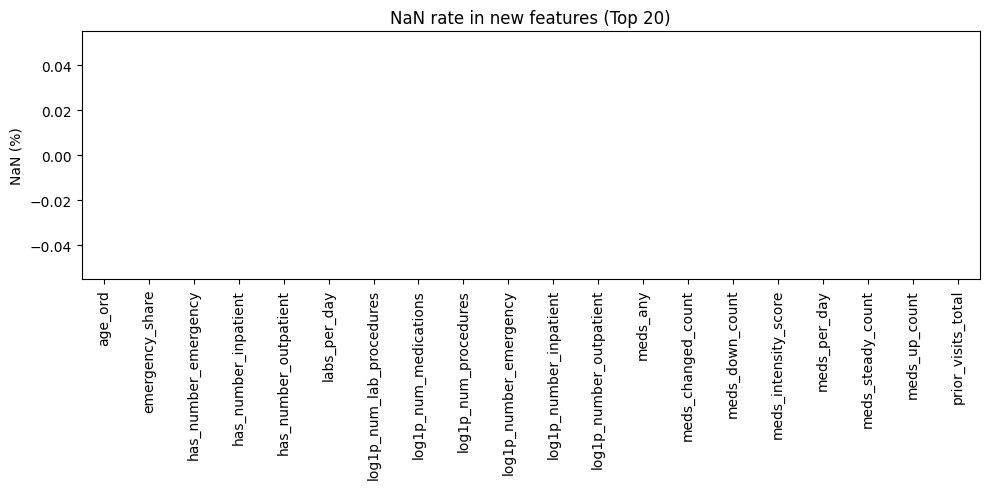

✅ Inf 값이 새 수치형 피처들에서 발견되지 않았습니다.


,nan_%,inf_count
age_ord,0.0,0
emergency_share,0.0,0
has_number_emergency,0.0,0
has_number_inpatient,0.0,0
has_number_outpatient,0.0,0
labs_per_day,0.0,0
log1p_num_lab_procedures,0.0,0
log1p_num_medications,0.0,0
log1p_num_procedures,0.0,0
log1p_number_emergency,0.0,0


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 새 피처 리스트
new_cols = sorted(list(set(X_train_fe.columns) - set(X_train.columns)))

# NaN 비율
nan_pct = (X_train_fe[new_cols].isna().mean() * 100).sort_values(ascending=False)

# Inf 개수(수치형만)
num_new_cols = [c for c in new_cols if pd.api.types.is_numeric_dtype(X_train_fe[c])]
inf_count = pd.Series(
    {c: int(np.isinf(X_train_fe[c].to_numpy(dtype=float, copy=False)).sum()) for c in num_new_cols}
).sort_values(ascending=False)

# --- 시각화 1: NaN% 상위 20개
topk = 20
plt.figure(figsize=(10, 5))
nan_pct.head(topk).plot(kind="bar")
plt.ylabel("NaN (%)")
plt.title(f"NaN rate in new features (Top {topk})")
plt.tight_layout()
plt.show()

# --- 시각화 2: Inf count 상위 20개 (Inf가 아예 없으면 안내)
if inf_count.sum() == 0:
    print("✅ Inf 값이 새 수치형 피처들에서 발견되지 않았습니다.")
else:
    plt.figure(figsize=(10, 5))
    inf_count.head(topk).plot(kind="bar")
    plt.ylabel("Inf count")
    plt.title(f"Inf count in new numeric features (Top {topk})")
    plt.tight_layout()
    plt.show()

# 표도 같이(원하면)
display(pd.DataFrame({
    "nan_%": nan_pct,
    "inf_count": pd.Series({c: inf_count.get(c, 0) for c in new_cols})
}).sort_values(["nan_%","inf_count"], ascending=False).head(30))

In [40]:
cols_to_check = ["labs_per_day","meds_per_day","procedures_per_day","emergency_share","prior_visits_total"]
display(X_train_fe[cols_to_check].describe().T)

,count,mean,std,min,25%,50%,75%,max
labs_per_day,81613.0,9.764163,6.203853,0.066667,5.466667,8.666667,13.000,55.500000
meds_per_day,81613.0,3.484429,1.959882,0.076923,2.125000,3.000000,4.375,21.000000
procedures_per_day,81613.0,0.300968,0.485315,0.000000,0.000000,0.125000,0.400,3.000000
emergency_share,81613.0,0.041976,0.130488,0.000000,0.000000,0.000000,0.000,0.973684
prior_visits_total,81613.0,1.210187,2.319588,0.000000,0.000000,0.000000,2.000,80.000000


In [41]:
med_cols = ["meds_any","meds_changed_count","meds_up_count","meds_down_count","meds_steady_count"]
display(X_train_fe[med_cols].describe().T)
print("meds_any rate:", X_train_fe["meds_any"].mean())

,count,mean,std,min,25%,50%,75%,max
meds_any,81613.0,0.770662,0.42041,0.0,1.0,1.0,1.0,1.0
meds_changed_count,81613.0,0.287699,0.487339,0.0,0.0,0.0,1.0,4.0
meds_up_count,81613.0,0.146129,0.370837,0.0,0.0,0.0,0.0,3.0
meds_down_count,81613.0,0.141571,0.356294,0.0,0.0,0.0,0.0,3.0
meds_steady_count,81613.0,0.891084,0.896516,0.0,0.0,1.0,1.0,6.0


meds_any rate: 0.7706615367649762


### 2) "모델링용 전처리" (원핫 + 결측처리)

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, classification_report, confusion_matrix
import numpy as np
import pandas as pd

# 타입 분리
num_cols = [c for c in X_train_fe.columns if pd.api.types.is_numeric_dtype(X_train_fe[c])]
cat_cols = [c for c in X_train_fe.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop"
)

def eval_model(pipe, Xtr, ytr, Xte, yte, name="model"):
    pipe.fit(Xtr, ytr)
    proba = pipe.predict_proba(Xte)[:, 1]

    roc = roc_auc_score(yte, proba)
    pr  = average_precision_score(yte, proba)
    print(f"\n[{name}] ROC-AUC={roc:.4f} | PR-AUC={pr:.4f}")

    p, r, thr = precision_recall_curve(yte, proba)
    f1 = (2*p*r/(p+r+1e-12))
    best_i = np.nanargmax(f1)
    best_thr = thr[max(best_i-1, 0)] if len(thr) else 0.5
    print(f"[{name}] Best F1 threshold ~ {best_thr:.3f} (F1={f1[best_i]:.4f}, P={p[best_i]:.4f}, R={r[best_i]:.4f})")

    pred = (proba >= best_thr).astype(int)
    print(confusion_matrix(yte, pred))
    print(classification_report(yte, pred, digits=4))
    return {"roc_auc": roc, "pr_auc": pr, "best_thr": float(best_thr)}

# 모델 1: 로지스틱(해석/베이스라인)
logit_pipe = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=3000, class_weight="balanced"))
])

# 모델 2: HGB(성능 베이스라인)
hgb_pipe = Pipeline([
    ("prep", preprocess),
    ("clf", HistGradientBoostingClassifier(max_iter=300, learning_rate=0.08, random_state=42))
])

res_logit = eval_model(logit_pipe, X_train_fe, y_train, X_test_fe, y_test, name="logit+FE")
res_hgb   = eval_model(hgb_pipe,   X_train_fe, y_train, X_test_fe, y_test, name="hgb+FE")

res_logit, res_hgb

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



[logit+FE] ROC-AUC=0.6688 | PR-AUC=0.2045
[logit+FE] Best F1 threshold ~ 0.553 (F1=0.2705, P=0.1951, R=0.4407)
[[14090  3912]
 [ 1203   948]]
              precision    recall  f1-score   support

           0     0.9213    0.7827    0.8464     18002
           1     0.1951    0.4407    0.2704      2151

    accuracy                         0.7462     20153
   macro avg     0.5582    0.6117    0.5584     20153
weighted avg     0.8438    0.7462    0.7849     20153



TypeError: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.

In [45]:
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, classification_report, confusion_matrix
import numpy as np

def eval_model(pipe, Xtr, ytr, Xte, yte, name="model"):
    pipe.fit(Xtr, ytr)
    proba = pipe.predict_proba(Xte)[:, 1]

    roc = roc_auc_score(yte, proba)
    pr  = average_precision_score(yte, proba)
    print(f"\n[{name}] ROC-AUC={roc:.4f} | PR-AUC={pr:.4f}")

    p, r, thr = precision_recall_curve(yte, proba)
    f1 = (2*p*r/(p+r+1e-12))
    best_i = np.nanargmax(f1)
    best_thr = thr[max(best_i-1, 0)] if len(thr) else 0.5
    print(f"[{name}] Best F1 threshold ~ {best_thr:.3f} (F1={f1[best_i]:.4f}, P={p[best_i]:.4f}, R={r[best_i]:.4f})")

    pred = (proba >= best_thr).astype(int)
    print(confusion_matrix(yte, pred))
    print(classification_report(yte, pred, digits=4))
    return {"roc_auc": roc, "pr_auc": pr, "best_thr": float(best_thr)}

# 1) 로지스틱(수정본)
res_logit = eval_model(logit_pipe, X_train_fe, y_train, X_test_fe, y_test, name="logit+FE (scaled+saga)")

# 2) HGB(수정본: dense onehot)
res_hgb = eval_model(hgb_pipe, X_train_fe, y_train, X_test_fe, y_test, name="hgb+FE (dense OHE)")

res_logit, res_hgb

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



[logit+FE (scaled+saga)] ROC-AUC=0.6688 | PR-AUC=0.2045
[logit+FE (scaled+saga)] Best F1 threshold ~ 0.553 (F1=0.2705, P=0.1951, R=0.4407)
[[14090  3912]
 [ 1203   948]]
              precision    recall  f1-score   support

           0     0.9213    0.7827    0.8464     18002
           1     0.1951    0.4407    0.2704      2151

    accuracy                         0.7462     20153
   macro avg     0.5582    0.6117    0.5584     20153
weighted avg     0.8438    0.7462    0.7849     20153



TypeError: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

num_cols = [c for c in X_train_fe.columns if pd.api.types.is_numeric_dtype(X_train_fe[c])]
cat_cols = [c for c in X_train_fe.columns if c not in num_cols]

preprocess_logit = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler(with_mean=False))  # sparse-safe
        ]), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop"
)

logit_pipe = Pipeline([
    ("prep", preprocess_logit),
    ("clf", LogisticRegression(
        solver="saga",          # <- 여기 핵심
        penalty="l2",
        max_iter=20000,         # <- 여유있게 크게
        tol=1e-3,               # <- 수렴 조금 완화
        class_weight="balanced",
        n_jobs=-1
    ))
])

# 혹시 정말 saga인지 확인
print("solver:", logit_pipe.named_steps["clf"].solver)

solver: saga


In [47]:
res_logit = eval_model(logit_pipe, X_train_fe, y_train, X_test_fe, y_test, name="logit+FE (scaled+saga)")


[logit+FE (scaled+saga)] ROC-AUC=0.6690 | PR-AUC=0.2036
[logit+FE (scaled+saga)] Best F1 threshold ~ 0.532 (F1=0.2704, P=0.1869, R=0.4886)
[[13429  4573]
 [ 1100  1051]]
              precision    recall  f1-score   support

           0     0.9243    0.7460    0.8256     18002
           1     0.1869    0.4886    0.2704      2151

    accuracy                         0.7185     20153
   macro avg     0.5556    0.6173    0.5480     20153
weighted avg     0.8456    0.7185    0.7663     20153



In [48]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

num_cols = [c for c in X_train_fe.columns if pd.api.types.is_numeric_dtype(X_train_fe[c])]
cat_cols = [c for c in X_train_fe.columns if c not in num_cols]

# (1) 일단 기존처럼 원핫(희소여도 상관없음)
preprocess_for_hgb = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop"
)

# (2) sparse -> dense 변환기 (sparse면 toarray(), 아니면 그대로)
to_dense = FunctionTransformer(
    lambda X: X.toarray() if hasattr(X, "toarray") else X,
    accept_sparse=True
)

hgb_pipe = Pipeline([
    ("prep", preprocess_for_hgb),
    ("dense", to_dense),   # <- 이 줄이 sparse 에러를 100% 막아줌
    ("clf", HistGradientBoostingClassifier(
        max_iter=400,
        learning_rate=0.06,
        random_state=42
    ))
])

res_hgb = eval_model(hgb_pipe, X_train_fe, y_train, X_test_fe, y_test, name="hgb+FE (dense via toarray)")


[hgb+FE (dense via toarray)] ROC-AUC=0.6798 | PR-AUC=0.2254
[hgb+FE (dense via toarray)] Best F1 threshold ~ 0.138 (F1=0.2825, P=0.2046, R=0.4565)
[[14183  3819]
 [ 1169   982]]
              precision    recall  f1-score   support

           0     0.9239    0.7879    0.8505     18002
           1     0.2045    0.4565    0.2825      2151

    accuracy                         0.7525     20153
   macro avg     0.5642    0.6222    0.5665     20153
weighted avg     0.8471    0.7525    0.7898     20153



1. PR 커브 시각화
2. Recall 목포에 맞는 threshold 자동 선택
3. 그 threshold에서 Precision/Recall/F1 + Confusion Matrix 출력

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, confusion_matrix

# 모델 학습(혹시 eval_model 내부에서만 fit해서, 여기서 다시 fit하는 게 안전)
logit_pipe.fit(X_train_fe, y_train)
hgb_pipe.fit(X_train_fe, y_train)

proba_logit = logit_pipe.predict_proba(X_test_fe)[:, 1]
proba_hgb   = hgb_pipe.predict_proba(X_test_fe)[:, 1]

print("logit ROC:", roc_auc_score(y_test, proba_logit), "PR:", average_precision_score(y_test, proba_logit))
print("hgb   ROC:", roc_auc_score(y_test, proba_hgb),   "PR:", average_precision_score(y_test, proba_hgb))

logit ROC: 0.6689716690913676 PR: 0.2036400780379329
hgb   ROC: 0.6798100743080822 PR: 0.22539445777234848


1. PR Curve시각화(두 모델 비교)

<Figure size 700x500 with 0 Axes>

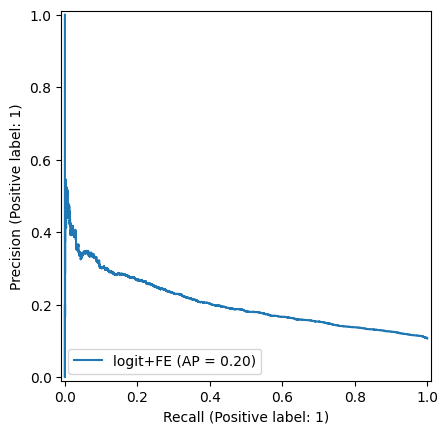

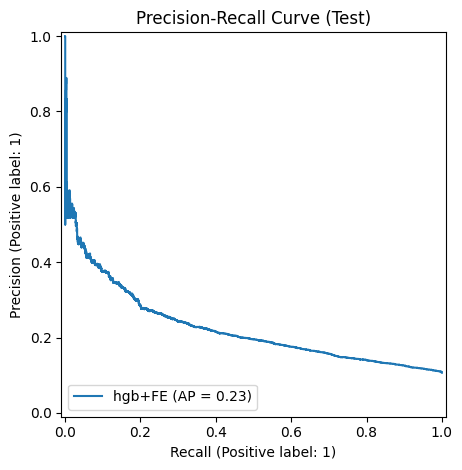

In [50]:
from sklearn.metrics import PrecisionRecallDisplay

plt.figure(figsize=(7,5))
PrecisionRecallDisplay.from_predictions(y_test, proba_logit, name="logit+FE")
PrecisionRecallDisplay.from_predictions(y_test, proba_hgb,   name="hgb+FE")
plt.title("Precision-Recall Curve (Test)")
plt.tight_layout()
plt.show()

2. “Recall 목표”에 맞춰 threshold 찾고, 성능표 출력

In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score

def threshold_for_recall(y_true, proba, recall_target):
    precision, recall, thresholds = precision_recall_curve(y_true, proba)
    # precision/recall 길이 = thresholds 길이 + 1
    # thresholds[i] -> precision[i+1], recall[i+1]에 해당
    valid = np.where(recall[1:] >= recall_target)[0]
    if len(valid) == 0:
        return None  # 해당 recall 달성 불가
    i = valid[-1]   # threshold를 가능한 크게(precision 확보)
    thr = thresholds[i]
    return float(thr)

def report_at_threshold(y_true, proba, thr, title=""):
    pred = (proba >= thr).astype(int)
    p = precision_score(y_true, pred, zero_division=0)
    r = recall_score(y_true, pred)
    f = f1_score(y_true, pred)
    cm = confusion_matrix(y_true, pred)
    tn, fp, fn, tp = cm.ravel()
    spec = tn / (tn + fp + 1e-12)

    print(f"\n[{title}] threshold={thr:.4f}")
    print(f"Precision={p:.4f} | Recall={r:.4f} | F1={f:.4f} | Specificity={spec:.4f}")
    print("Confusion matrix [[TN FP],[FN TP]]:")
    print(cm)

# 원하는 Recall 목표들
recall_targets = [0.40, 0.50, 0.60, 0.70, 0.80]

for rt in recall_targets:
    thr = threshold_for_recall(y_test, proba_hgb, rt)
    if thr is None:
        print(f"\n[hgb+FE] Recall target {rt:.2f}: 달성 불가")
    else:
        report_at_threshold(y_test, proba_hgb, thr, title=f"hgb+FE (Recall≥{rt:.2f})")


[hgb+FE (Recall≥0.40)] threshold=0.1498
Precision=0.2160 | Recall=0.4003 | F1=0.2806 | Specificity=0.8264
Confusion matrix [[TN FP],[FN TP]]:
[[14877  3125]
 [ 1290   861]]

[hgb+FE (Recall≥0.50)] threshold=0.1300
Precision=0.1958 | Recall=0.5002 | F1=0.2814 | Specificity=0.7545
Confusion matrix [[TN FP],[FN TP]]:
[[13582  4420]
 [ 1075  1076]]

[hgb+FE (Recall≥0.60)] threshold=0.1146
Precision=0.1757 | Recall=0.6002 | F1=0.2718 | Specificity=0.6636
Confusion matrix [[TN FP],[FN TP]]:
[[11946  6056]
 [  860  1291]]

[hgb+FE (Recall≥0.70)] threshold=0.0991
Precision=0.1571 | Recall=0.7001 | F1=0.2566 | Specificity=0.5510
Confusion matrix [[TN FP],[FN TP]]:
[[9919 8083]
 [ 645 1506]]

[hgb+FE (Recall≥0.80)] threshold=0.0823
Precision=0.1402 | Recall=0.8001 | F1=0.2385 | Specificity=0.4135
Confusion matrix [[TN FP],[FN TP]]:
[[ 7444 10558]
 [  430  1721]]


```
*   threshold ↓ → 더 많은 사람을 “고위험(<30)”으로 잡음 → Recall↑, Precision↓, FP (오탐)↑
*   threshold ↑ → 정말 높은 점수만 고위험으로 잡음 → Precision↑, Recall↓, FN(놓침)↑
```

```
Recall ≥ 0.50 (threshold=0.1300)

 * Recall 0.5002 → 실제 재입원 2151명 중 약 1076명(TP)을 잡음, 약 1075명(FN)을 놓침

 * Precision 0.1958 → “고위험”이라고 찍은 사람 중 19.6%만 진짜 재입원

 * FP=4420 → 재입원 아닌데 고위험으로 잡힌 사람이 4420명

 *  운영 관점: “절반은 잡는데, 경보(고위험 판정)는 많이 울림”

Recall ≥ 0.70 (threshold=0.0991)

- Recall 0.7001 → TP=1506, FN=645

- Precision 0.1571 → 고위험 판정 중 진짜는 15.7%

- FP=8083 (급증) / Specificity 0.5510 (절반 정도만 정상으로 맞춤)

- 운영 관점: “많이 놓치지 않게 잡지만, 오탐이 크게 늘어서 현장 부담 증가”

Recall ≥ 0.80 (threshold=0.0823)

- Recall 0.8001 → TP=1721, FN=430 (놓침은 확 줄어듦)

- Precision 0.1402 → 고위험 판정의 14%만 진짜

- FP=10558 (더 증가) / Specificity 0.4135

- 운영 관점: “놓치는 건 더 줄지만, 거의 ‘대량 경보’ 수준”
```



3. thresholdㅇ 따른 precision / Recall변화

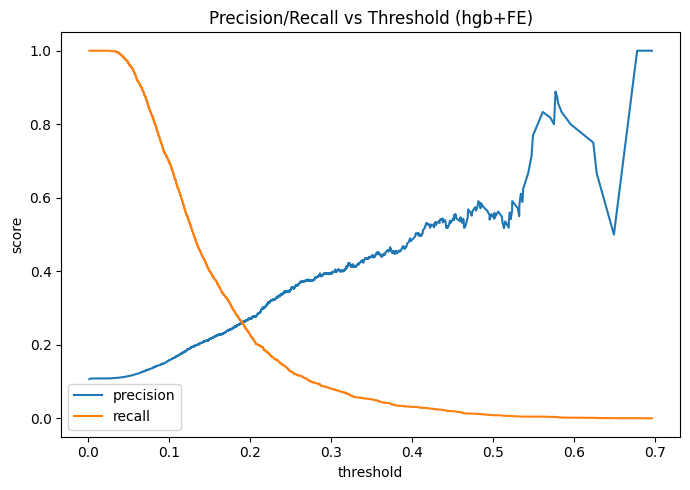

In [52]:
def plot_pr_vs_threshold(y_true, proba, name="model"):
    precision, recall, thresholds = precision_recall_curve(y_true, proba)
    # thresholds 길이 = len(precision)-1 이므로 맞춰서 plot
    plt.figure(figsize=(7,5))
    plt.plot(thresholds, precision[1:], label="precision")
    plt.plot(thresholds, recall[1:], label="recall")
    plt.xlabel("threshold")
    plt.ylabel("score")
    plt.title(f"Precision/Recall vs Threshold ({name})")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pr_vs_threshold(y_test, proba_hgb, name="hgb+FE")